In [ ]:
%%capture
!pip install fastai --upgrade
!pip install hub==1.1.1
!pip install segmentation-models-pytorch
!pip install rasterio
# Update the albumentations library
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
'''!conda uninstall pytorch --yes
!pip uninstall torch --yes
!pip uninstall torch --yes #(just to make sure)

!conda install pytorch-nightly cuda92 -c pytorch
!conda list
!pip list'''

'!conda uninstall pytorch --yes\n!pip uninstall torch --yes\n!pip uninstall torch --yes #(just to make sure)\n\n!conda install pytorch-nightly cuda92 -c pytorch\n!conda list\n!pip list'

In [ ]:

import matplotlib.pyplot as plt
import numpy 
from fastai.vision.all import *
import cv2
import hub
from hub import Dataset
import torch
from torch import nn
import torch.nn.functional as F
from numpy import *
import numpy as np
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms
import albumentations as A

In [ ]:
# Hekper function to cisualize the images
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
# Load data
ds = Dataset('rasha/SpaceNet_2_Las_Vegas')

# Use .numpy() to get the numpy array of the element
# Bands start from 0 here 
input_img = (ds["rgbs"][1100].numpy()).astype('uint8')
mask = (ds["masks"][1100].numpy()).astype('uint8')

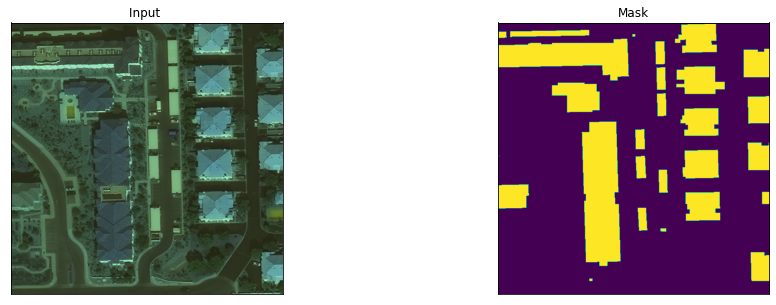

In [ ]:
visualize(input_ =input_img, mask=mask)

In [ ]:
# Create custom dataset that accepts 4 channels images
from torch.utils.data import Dataset, DataLoader, sampler
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from torchvision import transforms, datasets, models
# We have two dir: inputs(folder for each image) and tatgets

class SpaceNetDataset(BaseDataset):
    def __init__(self, dataset, 
               preprocessing = False,
               augmentation=None,
               pytorch=True):
        super().__init__()
        self.samples = ds
        self.pytorch = pytorch
        self.augmentation = augmentation
        self.preprocessing = preprocessing
  
    def __len__(self):
        return len(self.samples)
  
    def normalize(self, band):
        #'''Notmalize a numpy array to have values between 0 and 1'''  
        band_min, band_max = band.min(), band.max()
        np.seterr(divide='ignore', invalid='ignore')
        normalized_band = ((band - band_min)/(band_max - band_min))
        #Remove any nan value and subtitute by zero
        where_are_NaNs = isnan(normalized_band)
        normalized_band[where_are_NaNs] = 0
        
        return normalized_band
    
    def open_as_array(self, idx):
        # List indivisual bands in each image folder
        # Stack them togather
        # Self.samples --> samples['inputs'][idx] samples['rgb_inputs'][idx] samples['masks'][idx]
       
        raw_rgb = self.samples['rgbs'][idx].compute()
 
        if self.augmentation:
            # Crop the image or perform other augmentations
            transformed = self.augmentation(image = raw_rgb)
            raw_rgb  = transformed["image"]
 
        if self.preprocessing:
            # transpose to tensor shape
            raw_rgb = raw_rgb.transpose((2,0,1))
            # Convert to Tensor
            raw_rgb = torch.tensor(raw_rgb, dtype=torch.float)
            # Normalize the input bands
            for i in range(raw_rgb.shape[0]):
                raw_rgb[i, :, :] = self.normalize(raw_rgb[i, :, :])
        
        return raw_rgb
    
    def open_mask(self, idx):
        # Extract certain classes from mask
 
        mask = self.samples['masks'][idx].compute()
        if self.augmentation:
            transformed = self.augmentation(image = mask)
            mask  = transformed["image"]
      
        if self.preprocessing:
            # transpose to tensor shape
            mask_ = np.expand_dims(mask, 0).astype('float32')
            #mask = mask.transpose((2, 0, 1)).astype('float32') # mask shape [classes_channels, H, W]      
            # Normalize the mask bands
            mask_ = self.normalize(mask_)       
            
            # Convert to Tensor
            mask_ = torch.from_numpy(mask_)
        
        return mask_
    
    def __getitem__(self, idx):
        x = self.open_as_array(idx)
        y = self.open_mask(idx)
        
        return x, y
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())
        return s

In [ ]:

# Declare an augmentation pipeline

transform = A.Compose([
    A.CenterCrop(height=224, width=224),
    A.HorizontalFlip(p=0.5),
 
 
])

# Load data to Pytorch 
dataset = SpaceNetDataset(ds, preprocessing=True,
                           augmentation=transform)
'''x, y = dataset[1100]
#y = y[:, :, 0]
#plt.imshow(y[:, :, 0])

visualize(image = x, mask=y )
len(dataset)'''

valid_split = 0.2
batch_size = 32
# Create indices for the split
dataset_size = len(dataset)
valid_size = int(valid_split * dataset_size)
test_size = int(valid_split * dataset_size)
train_size = dataset_size - (valid_size + test_size)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset,
                                               [train_size, valid_size, test_size])
train_loader = DataLoader(
        train_dataset.dataset,
        batch_size=batch_size,
        shuffle=True)

valid_loader = DataLoader(
        valid_dataset.dataset,
        batch_size=batch_size,
        shuffle=True)
    

test_loader = DataLoader(
        test_dataset.dataset,
        batch_size=batch_size,
        shuffle=True)

In [ ]:
# Check the data loader
images, masks = iter(train_loader).next()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


In [ ]:
print(images.shape)
print(masks.shape)
# Check the max value in our normalized image
print(images[0].max())
print(masks[0].max())
print(images[0].min())
print(masks[0].min())
print(masks[0].dtype)
print(images[0])

torch.Size([32, 3, 224, 224])
torch.Size([32, 1, 224, 224])
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
torch.float32
tensor([[[0.2459, 0.2623, 0.2787,  ..., 0.2787, 0.3115, 0.2951],
         [0.2623, 0.2459, 0.2623,  ..., 0.2787, 0.2787, 0.2951],
         [0.2623, 0.2623, 0.2951,  ..., 0.2787, 0.2787, 0.2623],
         ...,
         [0.1148, 0.1639, 0.1803,  ..., 0.2131, 0.1475, 0.0984],
         [0.1475, 0.0984, 0.0820,  ..., 0.1148, 0.1148, 0.1148],
         [0.1639, 0.1311, 0.1148,  ..., 0.0984, 0.1148, 0.1148]],

        [[0.2936, 0.3028, 0.3028,  ..., 0.3486, 0.3761, 0.3578],
         [0.2936, 0.2844, 0.3028,  ..., 0.3486, 0.3578, 0.3578],
         [0.3028, 0.2936, 0.3211,  ..., 0.3486, 0.3486, 0.3394],
         ...,
         [0.1193, 0.1651, 0.1743,  ..., 0.2110, 0.1468, 0.1009],
         [0.1468, 0.1009, 0.0826,  ..., 0.1101, 0.1193, 0.1101],
         [0.1651, 0.1284, 0.1101,  ..., 0.1101, 0.1193, 0.1284]],

        [[0.2211, 0.2316, 0.2421,  ..., 0.2526, 0.2842, 0.2737],
     

In [ ]:

ENCODER = 'resnet50' #se_resnext50_32x4d  #Linknet
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None #'sigmoid'
DEVICE = 'cuda'
model = smp.FPN(ENCODER, activation=ACTIVATION, classes=1, in_channels=3)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
loss = smp.utils.losses.BCEWithLogitsLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.01),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device = DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device = DEVICE,
    verbose=True,
)

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = smp.FPN(checkpoint['encoder'], 
                        activation=checkpoint['activation'], 
                        classes=checkpoint['classes'],
                        in_channels=3)
    model.load_state_dict(checkpoint['state_dict'])
    return model

# load best saved checkpoint
model = load_checkpoint('/content/best_model (10).pth')
print(model)


FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [ ]:
# Notes:
## Start with Adam and then SGD
### Have larger batch size
####

# train model

max_score = 0
for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        # Saving the model
        checkpoint = {"encoder":ENCODER,
                      "activation":ACTIVATION,
                      "classes":1,
                      "in_channels":3,
                      "state_dict": model.state_dict()}
        
        torch.save(checkpoint, 'best_model.pth')
        
        print('Model saved!')
        
    if i == 30:
        files.download('/content/best_model.pth')

    if i == 60:
        files.download('/content/best_model.pth')

    if i == 85:
        files.download('/content/best_model.pth')
        model = load_checkpoint('best_model.pth')
        optimizer = torch.optim.SGD(model.parameters(), 1e-4)





Epoch: 0
train:   0%|          | 0/121 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


train:  43%|████▎     | 52/121 [1:06:10<2:26:41, 127.56s/it, bce_with_logits_loss - 0.7277, iou_score - 0.04022]

In [ ]:
from google.colab import files
files.download('/content/best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# load best saved checkpoint
# load best saved checkpoint
best_model = load_checkpoint('/content/best_model.pth')

print(best_model)


In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

# Reference
- https://github.com/activeloopai/Hub
-https://stackoverflow.com/questions/59218671/runtimeerror-output-with-shape-1-224-224-doesnt-match-the-broadcast-shape